This file's goal is to familiarize you with how the dataset is constructed.

It consists of: 
 1. Rendered images of our object
 2. Projection matrix of the object in our 3D space
 3. Global model view and projection matrices which depend on our camera (its intrinsic and extrinsic parameters)

The camera in the 3D world is placed at (0, 0, -1) position, looking perpendicular to the XY plane, and has 35 mm of focal length.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from json import load

from utils import project_points
plt.rcParams["figure.figsize"] = (10, 10)

The camera info file is global for the whole dataset so it stored in a separate file

It contains two important matricies for you to be able to project 3D points on a 2d image.

In [2]:
camera_info = load(open("./reference/camera_info.json"))

model_view_matrix = np.array(camera_info['model_view_matrix'])
projection_matrix = np.array(camera_info['projection_matrix'])

Bounding box points are the edges of our box that holds our model in a 3d world space coordinate system.

In [3]:
bounding_box_points_in_3d = np.float32(
    [(-0.156, -0.182, -0.032), 
     ( 0.156, -0.182, -0.032),
     (-0.156,  0.163, -0.032),
     ( 0.156,  0.163, -0.032),
     (-0.156, -0.182,  0.034),
     ( 0.156, -0.182,  0.034),
     (-0.156,  0.163,  0.034),
     ( 0.156,  0.163,  0.034)])

homogenious_bb_points = np.c_[bounding_box_points_in_3d, np.ones((8,1), dtype=np.float32)]

Here I created a smaller version of the dataset where our model is represented only in two positions:
1. From above
2. Side view

In [4]:
above_image = cv2.cvtColor(cv2.imread('./reference/0.jpg'), cv2.COLOR_BGR2RGB)
above_matrix = np.array(load(open("./reference/0_mat.json")))

In [5]:
side_image = cv2.cvtColor(cv2.imread('./reference/1.jpg'), cv2.COLOR_BGR2RGB)
side_matrix = np.array(load(open("./reference/1_mat.json")))

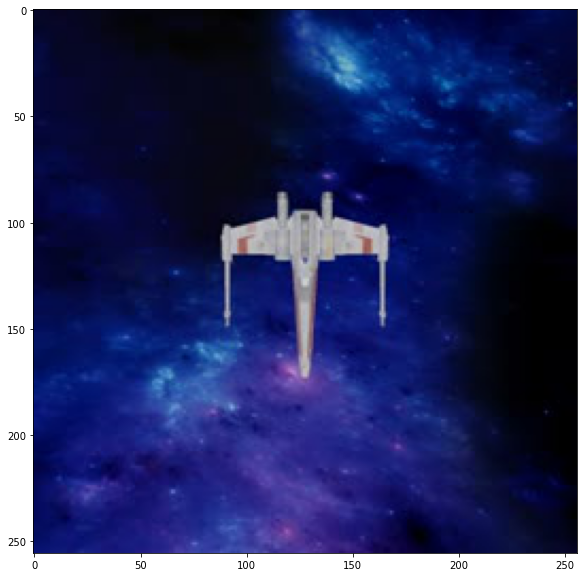

In [6]:
plt.imshow(above_image)

On above image model is placed at the origin and it dosen't have any rotation so it's matrix is obviously boring

In [7]:
above_matrix

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

If we project the axis on the image you will get a better understanding of placement in the 3D world

Notice that the Z axis is looking directly at the camera and is represented with a dot

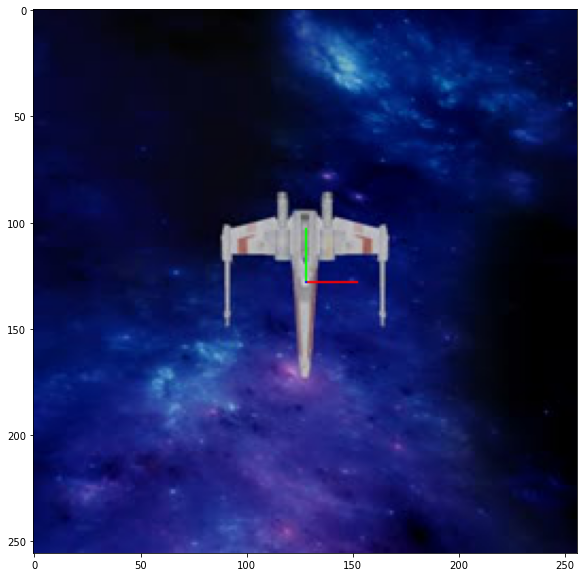

In [15]:
axis_points_3d = np.float32([[0.1, 0, 0, 1], [0, 0.1, 0, 1], [0, 0, 0.1, 1], [0, 0, 0, 1]])

projected_axis = project_points(above_image, axis_points_3d, model_view_matrix, projection_matrix, above_matrix)

xa, ya, za, center =[tuple(p) for p in np.array(projected_axis).astype(int)] 
img = above_image.copy()

img = cv2.line(img, center, xa, (255,0,0), 1)
img = cv2.line(img, center, ya, (0,255,0), 1)
img = cv2.line(img, center, za, (0,0,255), 1)

plt.imshow(img)

If we now project our bounding point you'll see how they look from camera perspective

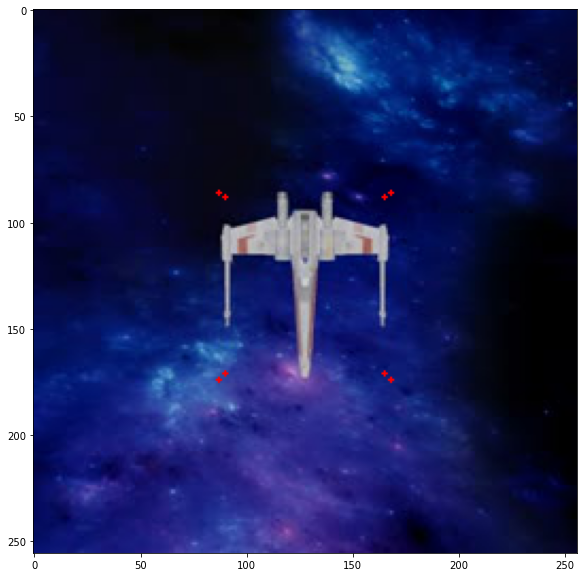

In [17]:
img = above_image.copy()
projected_bb = np.array(project_points(img, 
                                       homogenious_bb_points, 
                                       model_view_matrix, 
                                       projection_matrix, 
                                       above_matrix)).astype(int)

for pbb in projected_bb:
    img = cv2.circle(img, tuple(pbb), 1, (255,0,0), -1)

plt.imshow(img)

Now lets look how all of that will look if we turn our model

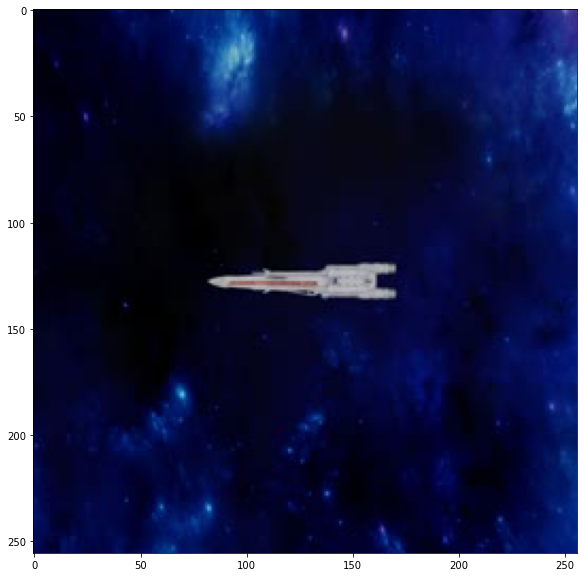

In [18]:
plt.imshow(side_image)

Axis will look the same because camera didn't move 

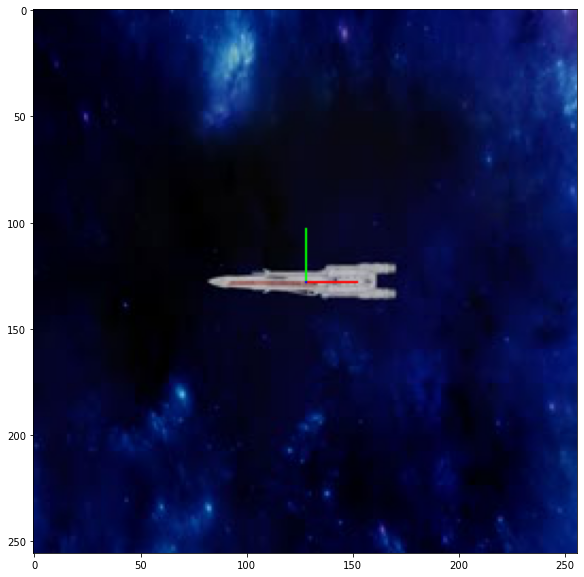

In [19]:
axis_points_3d = np.float32([[0.1, 0, 0, 1], [0, 0.1, 0, 1], [0, 0, 0.1, 1], [0, 0, 0, 1]])

projected_axis = project_points(side_image, axis_points_3d, model_view_matrix, projection_matrix, above_matrix)

xa, ya, za, center =[tuple(p) for p in np.array(projected_axis).astype(int)]
img = side_image.copy()

img = cv2.line(img, center, xa, (255,0,0), 1)
img = cv2.line(img, center, ya, (0,255,0), 1)
img = cv2.line(img, center, za, (0,0,255), 1)

plt.imshow(img)

But if you look at bounding points from when ship is rotated to its side they projection will look different

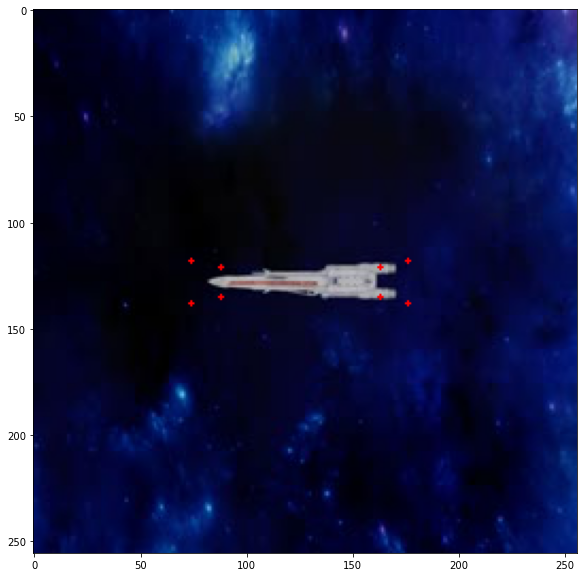

In [20]:
img = side_image.copy()
projected_bb = np.array(project_points(img, 
                                       homogenious_bb_points, 
                                       model_view_matrix, 
                                       projection_matrix, 
                                       side_matrix)).astype(int)

for pbb in projected_bb:
    img = cv2.circle(img, tuple(pbb), 1, (255,0,0), -1)

plt.imshow(img)

Projection is different because the transformation matrix for the rotated object is not the same as for the object in the above image

In [21]:
side_matrix

array([[-4.37113883e-08,  1.00000000e+00, -4.37113883e-08,
         0.00000000e+00],
       [-0.00000000e+00, -4.37113883e-08, -1.00000000e+00,
         0.00000000e+00],
       [-1.00000000e+00, -4.37113883e-08,  1.91068568e-15,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

Let's now go to our goal and draw some shooting lasers

In [22]:
lasers = np.float32((
    ((-0.145, -0.1, -0.01), (-0.145, -0.3, -0.01)),
    ((-0.145, -0.1,  0.01), (-0.145, -0.3,  0.01)),
    (( 0.145, -0.1, -0.01), ( 0.145, -0.3, -0.01)),
    (( 0.145, -0.1,  0.01), ( 0.145, -0.3,  0.01))
))

In [23]:
np.c_[lasers[0], np.ones((2,1), dtype=np.float32)]

array([[-0.145, -0.1  , -0.01 ,  1.   ],
       [-0.145, -0.3  , -0.01 ,  1.   ]], dtype=float32)

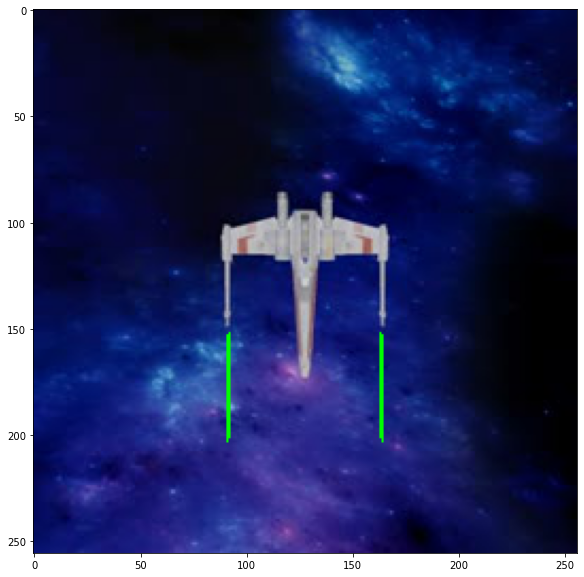

In [24]:
img = above_image.copy()
for lpts in lasers:
    h_lpts = np.c_[lpts, np.ones((2,1), dtype=np.float32)]
    points = project_points(img, h_lpts, model_view_matrix, projection_matrix, above_matrix)
    p1, p2 = np.array(points).astype(int)
    img = cv2.line(img, tuple(p1), tuple(p2), (0,255,0), 1)

plt.imshow(img)

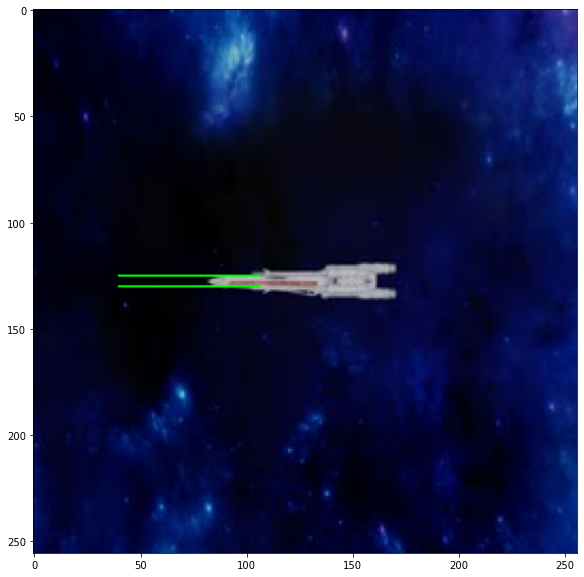

In [26]:
img = side_image.copy()
for lpts in lasers:
    h_lpts = np.c_[lpts, np.ones((2,1), dtype=np.float32)]
    points = project_points(img, h_lpts, model_view_matrix, projection_matrix, side_matrix)
    p1, p2 = np.array(points).astype(int)
    img = cv2.line(img, tuple(p1), tuple(p2), (0,255,0), 1)

plt.imshow(img)

And for the final let's get one image from our dataset

In [27]:
ds_image = cv2.cvtColor(cv2.imread('./dataset/0.jpg'), cv2.COLOR_BGR2RGB)
ds_matrix = np.array(load(open("./dataset/0_mat.json")))

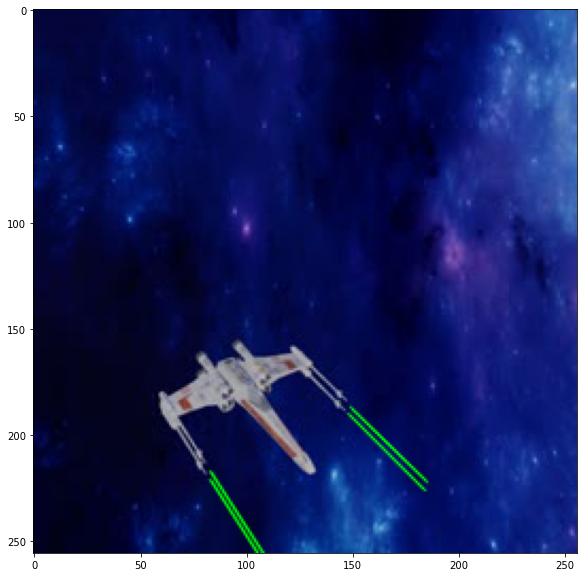

In [28]:
img = ds_image.copy()
for lpts in lasers:
    h_lpts = np.c_[lpts, np.ones((2,1), dtype=np.float32)]
    points = project_points(img, h_lpts, model_view_matrix, projection_matrix, ds_matrix)
    p1, p2 = np.array(points).astype(int)
    img = cv2.line(img, tuple(p1), tuple(p2), (0,255,0), 1, cv2.LINE_AA)

plt.imshow(img)

Pew Pew, isn't this cool as hell?